## Import the scripts 

In [184]:
%run Implied_Volatility.ipynb
%run Option_Greeks.ipynb

## Draw the Impied Volatility Graph of 0130 and 0131

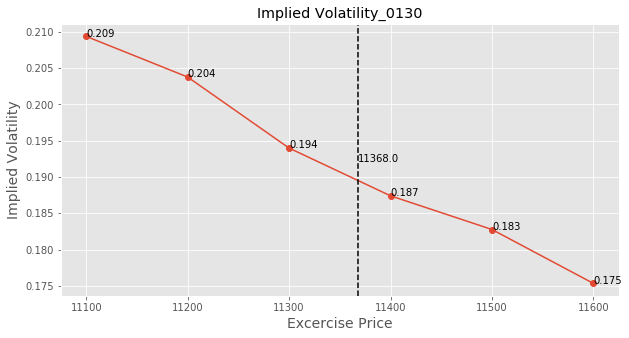

In [162]:
date_ = '0130'
S = todayStockPrice(date = date_)
list_StockPrices = moneyness_list(S, gapType = "month", gapNum = 3) # only 3 OTM price on monthly basis

# Split the df to df_call and df_put
df = df_generate(product = 'TXO', date = date_ )
df_put = df[df.買賣權 == 'Put'].reset_index(drop=True)
df_call = df[df.買賣權 == 'Call'].reset_index(drop=True)

# append the IV 
df_put = Flag_Moneyness(df_put, S = S, code = 'Put')
list_IV, categoryNAPut = IV_List(df = df_put, Stock = S, d = date_ , flag = 'Put')
df_put["IV"] = list_IV

df_call = Flag_Moneyness(df_call, S = S, code = 'Call')
list_IV, categoryNACall = IV_List(df = df_call, Stock = S, d = date_ , flag = 'Call')
df_call["IV"] = list_IV

# Combine call and put with only OTM 
df_OTM = combine_OTM(df_call, df_put, list_StockPrices)
plot_IV(df = df_OTM, S = S, date = date_)


In [163]:
df_OTM

,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,最後成交價,結算價,漲跌價,...,*盤後交易時段成交量,*一般交易時段成交量,*合計成交量,*未沖銷契約量,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,Moneyness,IV
14,TXO,202002,11100,Put,25.5,113,21,112,112.0,▲+103.4,...,86,8188,8274,5704,112,113.0,160,8.3,OTM,0.209381
15,TXO,202002,11200,Put,30,142,28,142,142.0,▲+131,...,177,14622,14799,10148,140,145.0,200,10.5,OTM,0.203777
16,TXO,202002,11300,Put,43,176,37,176,176.0,▲+161,...,332,19220,19552,9265,173,176.0,232,13.5,OTM,0.193986
17,TXO,202002,11400,Call,401,401,186,186,186.0,▼-549,...,0,1912,1912,1186,181,189.0,785,186,OTM,0.187406
18,TXO,202002,11500,Call,355,359,137,137,137.0,▼-498,...,0,4694,4694,2617,137,138.0,690,137,OTM,0.182766
19,TXO,202002,11600,Call,290,290,95,97,97.0,▼-448,...,5,7539,7544,2690,94,97.0,595,95,OTM,0.175334


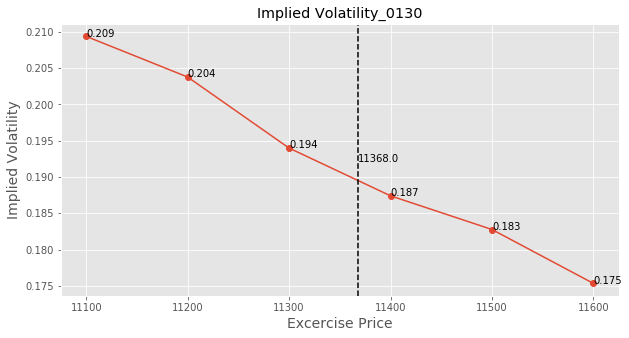

In [164]:
date_ = '0130'
S = todayStockPrice(date = date_)
list_StockPrices = moneyness_list(S, gapType = "month", gapNum = 3) # only 3 OTM price on monthly basis

# Split the df to df_call and df_put
df = df_generate(product = 'TXO', date = date_ )
df_put = df[df.買賣權 == 'Put'].reset_index(drop=True)
df_call = df[df.買賣權 == 'Call'].reset_index(drop=True)

# append the IV 
df_put = Flag_Moneyness(df_put, S = S, code = 'Put')
list_IV, categoryNAPut = IV_List(df = df_put, Stock = S, d = date_ , flag = 'Put')
df_put["IV"] = list_IV

df_call = Flag_Moneyness(df_call, S = S, code = 'Call')
list_IV, categoryNACall = IV_List(df = df_call, Stock = S, d = date_ , flag = 'Call')
df_call["IV"] = list_IV

# Combine call and put with only OTM 
df_OTM = combine_OTM(df_call, df_put, list_StockPrices)
plot_IV(df = df_OTM, S = S, date = date_)


## Calculate the Individual Option Greeks

In [165]:
s = 11368
exp_date = '20200219'
eval_date = '20200130'
rf = 0.0
div = 0.0

In [166]:
# Build up a delta table
list_k = list(df_call["履約價"])
delta_C = []
delta_P = []
for k in list_k:
    opt_C = Option(s=s, k=k, eval_date=eval_date, exp_date=exp_date, rf=rf, vol=vol, right='Call',
             div = div)
    delta_C.append(opt_C.get_greeks()[0])

    opt_P = Option(s=s, k=k, eval_date=eval_date, exp_date=exp_date, rf=rf, vol=vol, right='Put',
             div = div)
    delta_P.append(opt_P.get_greeks()[0])
    
df_delta = pd.DataFrame({'Excercise Price': list_k, 'Delta_C': delta_C, 'Delta_P': delta_P})
df_delta[10:25] # Search for certain area 

,Excercise Price,Delta_C,Delta_P
10,10700,0.908512,-0.091488
11,10800,0.870899,-0.129101
12,10900,0.824203,-0.175797
13,11000,0.768579,-0.231421
14,11100,0.704930,-0.295070
15,11200,0.634894,-0.365106
16,11300,0.560713,-0.439287
17,11400,0.485004,-0.514996
18,11500,0.410481,-0.589519
19,11600,0.339662,-0.660338


# Construct the Option Strategies 

### We expect the vega decrease, then we can construct the strategies with approximate delta neutral

### 1. Short Strangle: Sell 1 Call and Sell 1 Put 

In [174]:
df_call[df_call.履約價 == 11300] # delta_Call: 0.56

,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,最後成交價,結算價,漲跌價,...,*盤後交易時段成交量,*一般交易時段成交量,*合計成交量,*未沖銷契約量,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,Moneyness,IV
16,TXO,202002,11300,Call,483,494,245,245,245.0,▼-585,...,0,565,565,276,242,248.0,815,245,ITM,0.196352


In [175]:
df_put[df_put.履約價 == 11500] # delta_Put: -0.58

,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,最後成交價,結算價,漲跌價,...,*盤後交易時段成交量,*一般交易時段成交量,*合計成交量,*未沖銷契約量,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,Moneyness,IV
18,TXO,202002,11500,Put,85,268,66,265,265.0,▲+238.5,...,346,19597,19943,12163,264,268.0,324,23.5,ITM,0.179389


In [170]:
d_option1 = {'現貨價格': '11386', '到期日': '20200219', '買賣權': 'Call', '履約價': '11300', 
             '今日': '20200130', '部位': '-1', '結算價': '245.0', 'IV': '0.196352'}
d_option2 = {'現貨價格': '11386', '到期日': '20200219', '買賣權': 'Put', '履約價': '11500', 
             '今日': '20200130', '部位': '-1', '結算價': '265.0', 'IV': '0.179389'}

df_options_strangle = pd.DataFrame([d_option1, d_option2])
opt_strat1 = Options_strategy(df_options_strangle)
greeks_strat1 = opt_strat1.get_greeks()
opt_strat1.describe_portfolio()

Aggr. Delta: 0.010757385562554789
Aggr. Gamma: -0.0015537833653484524
Aggr. Theta: 9.721860478906741
Aggr. Vega: -20.98393882857018


max Payoff:  310.0


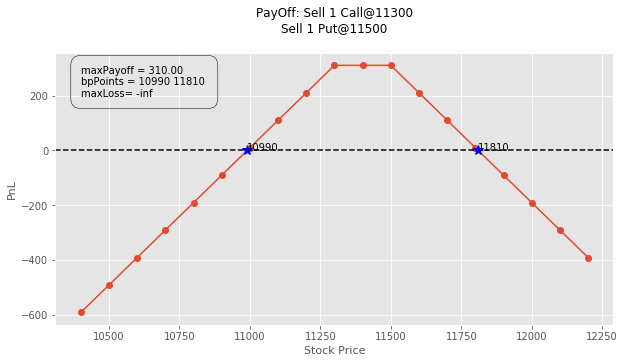

In [171]:
print("max Payoff: " , opt_strat1.get_maxPayoff())
opt_strat1.portfolio_payoff(fileName = "Short Strangle")

## 2. Long Condor

In [176]:
df_call[df_call.履約價 == 11100] # delta_Call: 0.27

,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,最後成交價,結算價,漲跌價,...,*盤後交易時段成交量,*一般交易時段成交量,*合計成交量,*未沖銷契約量,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,Moneyness,IV
14,TXO,202002,11100,Call,525,525,390,390,384.0,▼-630,...,0,188,188,122,377,387.0,1020,390,ITM,0.210976


In [177]:
df_put[df_put.履約價 == 11700] # delta_Put: -0.29 

,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,最後成交價,結算價,漲跌價,...,*盤後交易時段成交量,*一般交易時段成交量,*合計成交量,*未沖銷契約量,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,Moneyness,IV
20,TXO,202002,11700,Put,130,397,117,388,388.0,▲+340,...,837,16522,17359,9127,386,400.0,430,41,ITM,0.166417


In [179]:
d_option3 = {'現貨價格': '11386', '到期日': '20200219', '買賣權': 'Call', '履約價': '11100', 
             '今日': '20200130', '部位': '1', '結算價': '384.0', 'IV': '0.210976'}
d_option4 = {'現貨價格': '11386', '到期日': '20200219', '買賣權': 'Put', '履約價': '11700', 
             '今日': '20200130', '部位': '1', '結算價': '388.0', 'IV': '0.166417'}

df_options_condor = pd.DataFrame([d_option1, d_option2, d_option3, d_option4])
opt_strat2 = Options_strategy(df_options_condor)
greeks_strat2 = opt_strat2.get_greeks()
opt_strat2.describe_portfolio()

Aggr. Delta: -0.034893577029446066
Aggr. Gamma: -0.00023181925762599353
Aggr. Theta: 1.3978179773737112
Aggr. Vega: -3.1809121974342727


max Payoff:  138.0


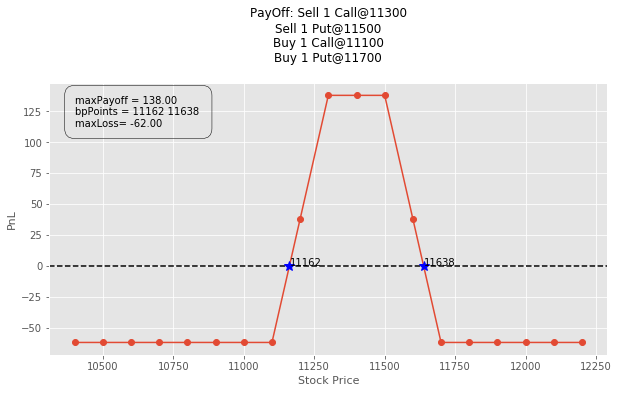

In [180]:
print("max Payoff: " , opt_strat2.get_maxPayoff())
opt_strat2.portfolio_payoff(fileName = "Long Condor")

### if we offset the stratrgy tomorrow

## 1. Short Strangle

In [185]:
# 0130 
cost_ss0130 = get_optionPrice(date = "0130", right = "Call", k = 11300) + get_optionPrice(date = "0130", right = "Put", k = 11500)
cost_ss0130

510.0

In [186]:
# 0131
cost_ss0131 = get_optionPrice(date = "0131", right = "Call", k = 11300) + get_optionPrice(date = "0131", right = "Put", k = 11500)
cost_ss0131

479.0

In [193]:
# Short 1 call and 1 put and Buy back tomorrow
Pnl_ss = cost_ss0130 -  cost_ss0131
Pnl_ss

31.0

## 2. Long Condor

In [190]:
cost_lc0130 = cost_ss0130 - get_optionPrice(date = "0130", right = "Call", k = 11100) - get_optionPrice(date = "0130", right = "Put", k = 11700)
cost_lc0130

-262.0

In [191]:
cost_lc0131 = cost_ss0131 - get_optionPrice(date = "0131", right = "Call", k = 11100) - get_optionPrice(date = "0131", right = "Put", k = 11700)
cost_lc0131

-266.0

In [195]:
# Long Condor and Sell back tomorrow
Pnl_lc = cost_lc0130 -  cost_lc0131
Pnl_lc

4.0